Deep Learning Assignment No:4

Title:Use Autoencoder to implement anomaly detection.

Name:Pranit Dilip Menkar

BEIT

Roll no: 49

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
RANDOM_SEED = 2021 
TEST_PCT = 0.3
LABELS = ["Normal","Fraud"]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("creditcard.csv")  




In [ ]:
#check for any  nullvalues 
print("Any nulls in the dataset ",dataset.isnull().values.any() )
print('-------')
print("No. of unique labels ", len(dataset['Class'].unique()))
print("Label values ",dataset.Class.unique())
#0 is for normal credit card transaction
#1 is for fraudulent credit card transaction
print('-------')
print("Break down of the Normal and Fraud Transactions")
print(pd.value_counts(dataset['Class'], sort = True) )


Any nulls in the dataset  True
-------
No. of unique labels  3
Label values  [ 0.  1. nan]
-------
Break down of the Normal and Fraud Transactions
0.0    11906
1.0       52
Name: Class, dtype: int64


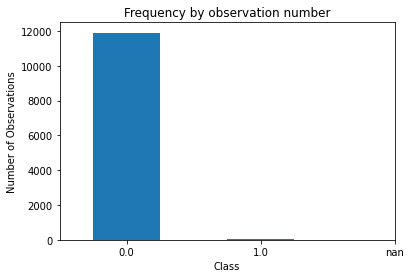

In [ ]:
#Visualizing the imbalanced dataset
#plotting the number of normal and fraud transactions in the dataset.
count_classes = pd.value_counts(dataset['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(len(dataset['Class'].unique())), dataset.Class.unique())
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [ ]:
#The last column in the dataset is our target variable.
raw_data = dataset.values
# The last element contains if the transaction is normal which is represented by a 0 and if fraud then 1
labels = raw_data[:, -1]
# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=2021
)

In [ ]:
#Normalize the data to have a value between 0 and 1
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)
train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)
train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [ ]:
# Use only normal transactions to train the Autoencoder.
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)
#creating normal and fraud datasets
normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]
fraud_train_data = train_data[train_labels]
fraud_test_data = test_data[test_labels]
print(" No. of records in Fraud Train Data=",len(fraud_train_data))
print(" No. of records in Normal Train data=",len(normal_train_data))
print(" No. of records in Fraud Test Data=",len(fraud_test_data))
print(" No. of records in Normal Test data=",len(normal_test_data))

 No. of records in Fraud Train Data= 44
 No. of records in Normal Train data= 9523
 No. of records in Fraud Test Data= 9
 No. of records in Normal Test data= 2383


In [ ]:
#Set the training parameter values
nb_epoch = 50
batch_size = 64
input_dim = normal_train_data.shape[1] #num of columns, 30
encoding_dim = 14
hidden_dim_1 = int(encoding_dim / 2) #
hidden_dim_2=4  
learning_rate = 1e-7



In [ ]:
#Create the Autoencoder

#input Layer
input_layer = tf.keras.layers.Input(shape=(input_dim, ))
#Encoder
encoder = tf.keras.layers.Dense(encoding_dim, activation="tanh",activity_regularizer=tf.keras.regularizers.l2(learning_rate))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(hidden_dim_2, activation=tf.nn.leaky_relu)(encoder)
# Decoder
decoder = tf.keras.layers.Dense(hidden_dim_1, activation='relu')(encoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(encoding_dim, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(input_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 14)                434       
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 105       
                                                                 
 dense_2 (Dense)             (None, 4)                 32        
                                                                 
 dense_3 (Dense)             (None, 7)                 35        
                                                                 
 dropout_1 (Dropout)         (None, 7)                 0     

In [ ]:
# Define the callbacks for checkpoints and early stopping

cp = tf.keras.callbacks.ModelCheckpoint(filepath="autoencoder_fraud.h5",
                               mode='min', monitor='val_loss', verbose=2, save_best_only=True)

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=10,
    verbose=1, 
    mode='min',
    restore_best_weights=True)


In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_data, test_data),
                    verbose=1,
                    callbacks=[cp, early_stop]
                    ).history

Epoch 1/50
149/149 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9392
Epoch 1: val_loss did not improve from inf
149/149 [==============================] - 3s 13ms/step - loss: 0.0038 - accuracy: 0.9392 - val_loss: nan - val_accuracy: 0.9929
Epoch 2/50
143/149 [===========================>..] - ETA: 0s - loss: 7.3412e-04 - accuracy: 0.9909
Epoch 2: val_loss did not improve from inf
149/149 [==============================] - 1s 9ms/step - loss: 7.2138e-04 - accuracy: 0.9911 - val_loss: nan - val_accuracy: 0.9929
Epoch 3/50
149/149 [==============================] - ETA: 0s - loss: 3.6164e-04 - accuracy: 0.9911
Epoch 3: val_loss did not improve from inf
149/149 [==============================] - 1s 8ms/step - loss: 3.6164e-04 - accuracy: 0.9911 - val_loss: nan - val_accuracy: 0.9929
Epoch 4/50
136/149 [==========================>...] - ETA: 0s - loss: 2.3946e-04 - accuracy: 0.9909
Epoch 4: val_loss did not improve from inf
149/149 [==============================

In [ ]:
# Detect Anomalies on test data
test_x_predictions = autoencoder.predict(test_data)
mse = np.mean(np.power(test_data - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_labels})

75/75 [==============================] - 0s 2ms/step


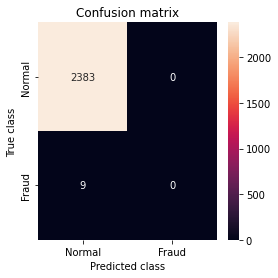

In [ ]:
threshold_fixed =52
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
error_df['pred'] =pred_y
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
